## LGBM - Google Analytics Customer Revenue Prediction
* Note: this is just a starting point, there's a lot of work to be done.*
* I also have a [deep learning](https://www.kaggle.com/dimitreoliveira/deep-learning-keras-ga-revenue-prediction) version of this code, this one is supposed to be a comparation between the models.
* I'm new to LGBM if you have any tip or correction please let me know.

### Dependencies

In [1]:
import os
import json
import datetime
import numpy as np
import pandas as pd
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
from sklearn.metrics import mean_squared_error

%matplotlib inline
pd.options.display.max_columns = 999

### Auxiliar functions

In [2]:
def add_time_features(df):
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d', errors='ignore')
    df['year'] = df['date'].apply(lambda x: x.year)
    df['month'] = df['date'].apply(lambda x: x.month)
    df['day'] = df['date'].apply(lambda x: x.day)
    df['weekday'] = df['date'].apply(lambda x: x.weekday())
    
    return df

Function to load and convert files borrowed from this [kernel](https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields/notebook), thanks!

In [3]:
def load_df(csv_path='../input/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']

    df = pd.read_csv(csv_path, dtype={'fullVisitorId': 'str'}, nrows=nrows)

    for column in JSON_COLUMNS:
        df = df.join(pd.DataFrame(df.pop(column).apply(pd.io.json.loads).values.tolist(), index=df.index))

    return df

In [4]:
train = load_df("../input/train.csv")
test = load_df("../input/test.csv")

### About the train data

In [5]:
train.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,browser,browserSize,browserVersion,deviceCategory,flashVersion,isMobile,language,mobileDeviceBranding,mobileDeviceInfo,mobileDeviceMarketingName,mobileDeviceModel,mobileInputSelector,operatingSystem,operatingSystemVersion,screenColors,screenResolution,city,cityId,continent,country,latitude,longitude,metro,networkDomain,networkLocation,region,subContinent,bounces,hits,newVisits,pageviews,transactionRevenue,visits,adContent,adwordsClickInfo,campaign,campaignCode,isTrueDirect,keyword,medium,referralPath,source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Izmir,not available in demo dataset,Asia,Turkey,not available in demo dataset,not available in demo dataset,(not set),ttnet.com.tr,not available in demo dataset,Izmir,Western Asia,1,1,1,1,NaN,1,NaN,{'criteriaParameters': 'not available in demo ...,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Oceania,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,Australasia,1,1,1,1,NaN,1,NaN,{'criteriaParameters': 'not available in demo ...,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Madrid,not available in demo dataset,Europe,Spain,not available in demo dataset,not available in demo dataset,(not set),unknown.unknown,not available in demo dataset,Community of Madrid,Southern Europe,1,1,1,1,NaN,1,NaN,{'criteriaParameters': 'not available in demo ...,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Asia,Indonesia,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,Southeast Asia,1,1,1,1,NaN,1,NaN,{'criteriaParameters': 'not available in demo ...,(not set),NaN,NaN,go

### This is how our data looks like

In [6]:
print('TRAIN SET')
print('Rows: %s' % train.shape[0])
print('Columns: %s' % train.shape[1])
print('Features: %s' % train.columns.values)
print()
print('TEST SET')
print('Rows: %s' % test.shape[0])
print('Columns: %s' % test.shape[1])
print('Features: %s' % test.columns.values)

TRAIN SET
Rows: 903653
Columns: 50
Features: ['channelGrouping' 'date' 'fullVisitorId' 'sessionId'
 'socialEngagementType' 'visitId' 'visitNumber' 'visitStartTime' 'browser'
 'browserSize' 'browserVersion' 'deviceCategory' 'flashVersion' 'isMobile'
 'language' 'mobileDeviceBranding' 'mobileDeviceInfo'
 'mobileDeviceMarketingName' 'mobileDeviceModel' 'mobileInputSelector'
 'operatingSystem' 'operatingSystemVersion' 'screenColors'
 'screenResolution' 'city' 'cityId' 'continent' 'country' 'latitude'
 'longitude' 'metro' 'networkDomain' 'networkLocation' 'region'
 'subContinent' 'bounces' 'hits' 'newVisits' 'pageviews'
 'transactionRevenue' 'visits' 'adContent' 'adwordsClickInfo' 'campaign'
 'campaignCode' 'isTrueDirect' 'keyword' 'medium' 'referralPath' 'source']

TEST SET
Rows: 804684
Columns: 48
Features: ['channelGrouping' 'date' 'fullVisitorId' 'sessionId'
 'socialEngagementType' 'visitId' 'visitNumber' 'visitStartTime' 'browser'
 'browserSize' 'browserVersion' 'deviceCategory' 'flash

### Feature engineering

In [7]:
train = add_time_features(train)
test = add_time_features(test)
# Convert feature types.
train["transactionRevenue"] = train["transactionRevenue"].astype('float')
train['hits'] = train['hits'].astype(float)
test['hits'] = test['hits'].astype(float)
train['pageviews'] = train['pageviews'].astype(float)
test['pageviews'] = test['pageviews'].astype(float)

### Agregated features.

In [8]:
# Train
gp_fullVisitorId_train = train.groupby(['fullVisitorId']).agg('sum')
gp_fullVisitorId_train['fullVisitorId'] = gp_fullVisitorId_train.index
gp_fullVisitorId_train['mean_hits_per_day'] = gp_fullVisitorId_train.groupby(['day'])['hits'].transform('mean')
gp_fullVisitorId_train['mean_pageviews_per_day'] = gp_fullVisitorId_train.groupby(['day'])['pageviews'].transform('mean')
gp_fullVisitorId_train['sum_hits_per_day'] = gp_fullVisitorId_train.groupby(['day'])['hits'].transform('sum')
gp_fullVisitorId_train['sum_pageviews_per_day'] = gp_fullVisitorId_train.groupby(['day'])['pageviews'].transform('sum')
gp_fullVisitorId_train = gp_fullVisitorId_train[['fullVisitorId', 'mean_hits_per_day', 'mean_pageviews_per_day', 'sum_hits_per_day', 'sum_pageviews_per_day']]
train = train.join(gp_fullVisitorId_train, on='fullVisitorId', how='inner', rsuffix='_')
train.drop(['fullVisitorId_'], axis=1, inplace=True)

# Test
gp_fullVisitorId_test = test.groupby(['fullVisitorId']).agg('sum')
gp_fullVisitorId_test['fullVisitorId'] = gp_fullVisitorId_test.index
gp_fullVisitorId_test['mean_hits_per_day'] = gp_fullVisitorId_test.groupby(['day'])['hits'].transform('mean')
gp_fullVisitorId_test['mean_pageviews_per_day'] = gp_fullVisitorId_test.groupby(['day'])['pageviews'].transform('mean')
gp_fullVisitorId_test['sum_hits_per_day'] = gp_fullVisitorId_test.groupby(['day'])['hits'].transform('sum')
gp_fullVisitorId_test['sum_pageviews_per_day'] = gp_fullVisitorId_test.groupby(['day'])['pageviews'].transform('sum')
gp_fullVisitorId_test = gp_fullVisitorId_test[['fullVisitorId', 'mean_hits_per_day', 'mean_pageviews_per_day', 'sum_hits_per_day', 'sum_pageviews_per_day']]
test = test.join(gp_fullVisitorId_test, on='fullVisitorId', how='inner', rsuffix='_')
test.drop(['fullVisitorId_'], axis=1, inplace=True)

In [9]:
train.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,browser,browserSize,browserVersion,deviceCategory,flashVersion,isMobile,language,mobileDeviceBranding,mobileDeviceInfo,mobileDeviceMarketingName,mobileDeviceModel,mobileInputSelector,operatingSystem,operatingSystemVersion,screenColors,screenResolution,city,cityId,continent,country,latitude,longitude,metro,networkDomain,networkLocation,region,subContinent,bounces,hits,newVisits,pageviews,transactionRevenue,visits,adContent,adwordsClickInfo,campaign,campaignCode,isTrueDirect,keyword,medium,referralPath,source,year,month,day,weekday,mean_hits_per_day,mean_pageviews_per_day,sum_hits_per_day,sum_pageviews_per_day
0,Organic Search,2016-09-02,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Izmir,not available in demo dataset,Asia,Turkey,not available in demo dataset,not available in demo dataset,(not set),ttnet.com.tr,not available in demo dataset,Izmir,Western Asia,1,1.0,1,1.0,NaN,1,NaN,{'criteriaParameters': 'not available in demo ...,(not set),NaN,NaN,(not provided),organic,NaN,google,2016,9,2,4,3.943076,3.371298,83747.0,71603.0
1,Organic Search,2016-09-02,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Oceania,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,Australasia,1,1.0,1,1.0,NaN,1,NaN,{'criteriaParameters': 'not available in demo ...,(not set),NaN,NaN,(not provided),organic,NaN,google,2016,9,2,4,3.943076,3.371298,83747.0,71603.0
2,Organic Search,2016-09-02,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Madrid,not available in demo dataset,Europe,Spain,not available in demo dataset,not available in demo dataset,(not set),unknown.unknown,not available in demo dataset,Community of Madrid,Southern Europe,1,1.0,1,1.0,NaN,1,NaN,{'criteriaParameters': 'not available in demo ...,(not set),NaN,NaN,(not provided),organic,NaN,google,2016,9,2,4,3.943076,3.371298,83747.0,71603.0
3,Organic Search,2016-09-02,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Asia,Indonesia,not availab

### Exploratory data analysis

#### Let's take a look at our target value through the time.

In [10]:
time_agg = train.groupby('date')['transactionRevenue'].agg(['count', 'sum'])
year_agg = train.groupby('year')['transactionRevenue'].agg(['sum'])
month_agg = train.groupby('month')['transactionRevenue'].agg(['sum'])
day_agg = train.groupby('day')['transactionRevenue'].agg(['sum'])
weekday_agg = train.groupby('weekday')['transactionRevenue'].agg(['count','sum'])

#### Here is sum of our tagert feature "transactionRevenue" through the time.

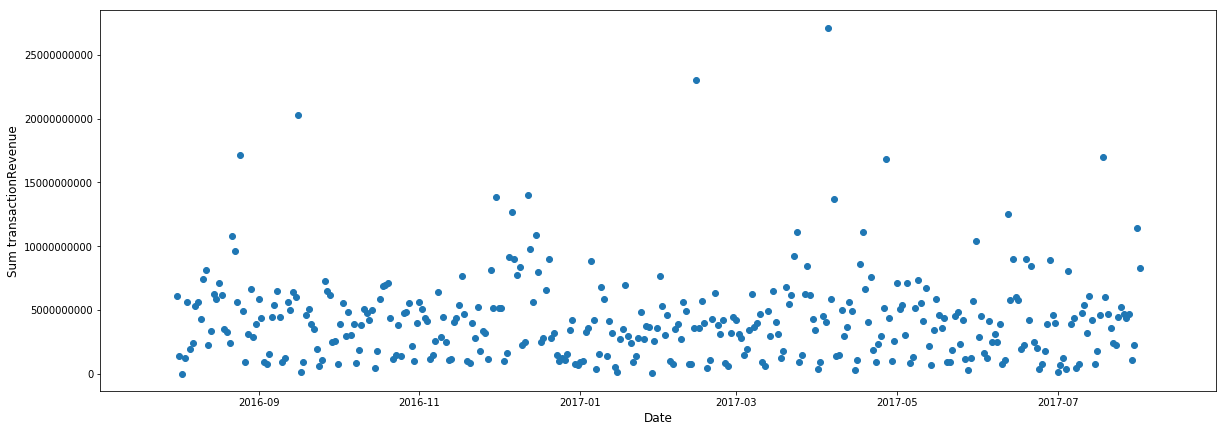

In [11]:
plt.figure(figsize=(20,7))
plt.ticklabel_format(axis='y', style='plain')
plt.ylabel('Sum transactionRevenue', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.scatter(time_agg.index.values, time_agg['sum'])
plt.show()

Seems we had more transactions on late 2016 and early 2017, date features seems to be a good addition to our model.

#### And here count of our target feature "transactionRevenue".

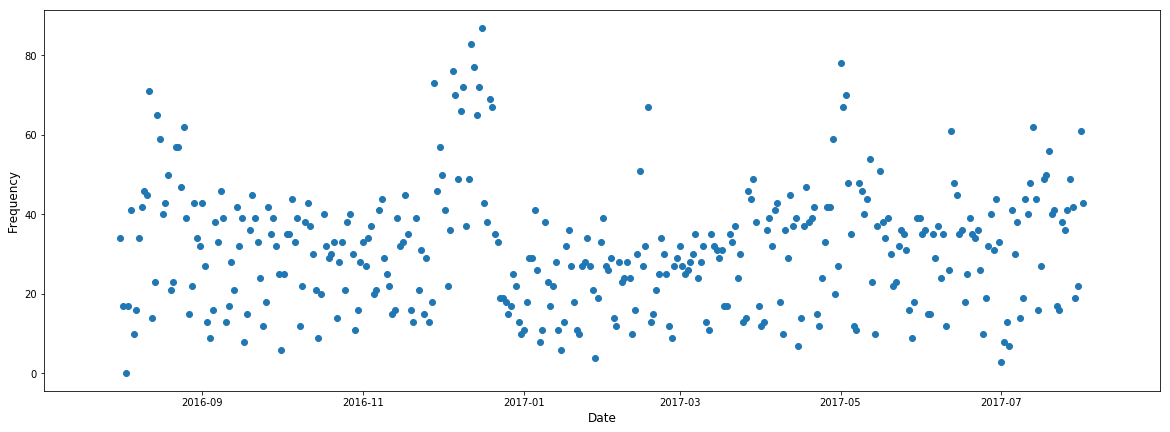

In [12]:
plt.figure(figsize=(20,7))
plt.ticklabel_format(axis='y', style='plain')
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.scatter(time_agg.index.values, time_agg['count'])
plt.show()

Again we had higher frequency at a similar time period.

#### Let's take a look at other time features.

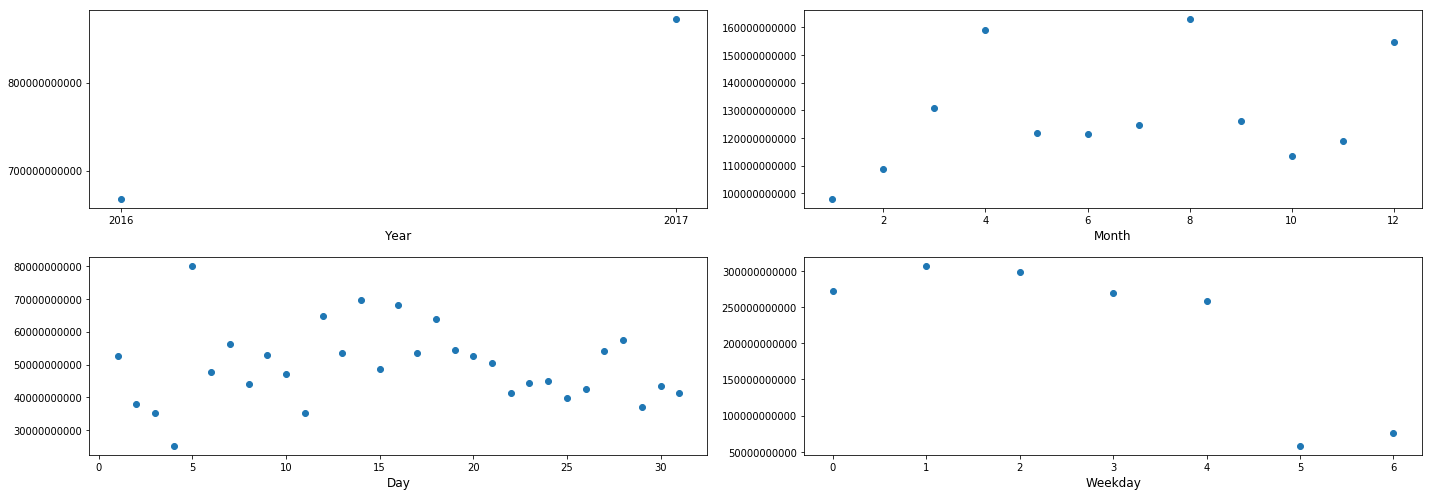

In [13]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20,7))
ax1.scatter(year_agg.index.values, year_agg['sum'])
ax1.locator_params(nbins=2)
ax1.ticklabel_format(axis='y', style='plain')
ax1.set_xlabel('Year', fontsize=12)

ax2.scatter(month_agg.index.values, month_agg['sum'])
ax2.locator_params(nbins=12)
ax2.ticklabel_format(axis='y', style='plain')
ax2.set_xlabel('Month', fontsize=12)

ax3.scatter(day_agg.index.values, day_agg['sum'])
ax3.locator_params(nbins=10)
ax3.ticklabel_format(axis='y', style='plain')
ax3.set_xlabel('Day', fontsize=12)

ax4.scatter(weekday_agg.index.values, weekday_agg['sum'])
ax4.locator_params(nbins=7)
ax4.ticklabel_format(axis='y', style='plain')
ax4.set_xlabel('Weekday', fontsize=12)

plt.tight_layout()
plt.show()

### About the engineered time features
* Year: It seem transactions had a large increase from 2016 to 2017
* Month: Lager transaction on december seems ok, but about months but im not sure why high values on april and august (maybe because of easter (april) or Tax-free weekend, back-to-school season(august)?)
* Day: Here it seems that not really important is going on, seems this features can be discarded.
* Weekday: Something strange is going on here, seems that weekends have less transactions?

### The let's do some cleaning

In [14]:
# Drop stange 'dict' column
train = train.drop(['adwordsClickInfo'], axis=1)
test = test.drop(['adwordsClickInfo'], axis=1)
# Drop column that exists only in train data
train = train.drop(['campaignCode'], axis=1)
# Input missing transactionRevenue values
train["transactionRevenue"].fillna(0, inplace=True)

test_ids = test["fullVisitorId"].values

### Drop unwanted columns

In [15]:
# Unwanted columns
unwanted_columns = ['fullVisitorId', 'sessionId', 'visitId', 'visitStartTime', 
                    'browser', 'browserSize', 'browserVersion', 'flashVersion', 
                    'mobileDeviceInfo', 'mobileDeviceMarketingName', 'mobileDeviceModel', 
                    'mobileInputSelector', 'operatingSystemVersion', 'screenColors', 
                    'metro','networkDomain', 'networkLocation', 'adContent', 'campaign', 
                    'isTrueDirect', 'keyword', 'referralPath', 'source', 'operatingSystem', 
                    'day']

train = train.drop(unwanted_columns, axis=1)
test = test.drop(unwanted_columns, axis=1)
# Constant columns
constant_columns = [c for c in train.columns if train[c].nunique()<=1]
print('Columns with constant values: ', constant_columns)
train = train.drop(constant_columns, axis=1)
test = test.drop(constant_columns, axis=1)
# Columns with more than 50% null data
high_null_columns = [c for c in train.columns if train[c].count()<=len(train) * 0.5]
print('Columns more than 50% null values: ', high_null_columns)
train = train.drop(high_null_columns, axis=1)
test = test.drop(high_null_columns, axis=1)

Columns with constant values:  ['socialEngagementType', 'language', 'mobileDeviceBranding', 'screenResolution', 'cityId', 'latitude', 'longitude', 'bounces', 'newVisits', 'visits']
Columns more than 50% null values:  []


### This is our new data with some cleaning and engineering.

In [16]:
print('TRAIN SET')
print('Rows: %s' % train.shape[0])
print('Columns: %s' % train.shape[1])
print('Features: %s' % train.columns.values)
print()
print('TEST SET')
print('Rows: %s' % test.shape[0])
print('Columns: %s' % test.shape[1])
print('Features: %s' % test.columns.values)

TRAIN SET
Rows: 903653
Columns: 21
Features: ['channelGrouping' 'date' 'visitNumber' 'deviceCategory' 'isMobile' 'city'
 'continent' 'country' 'region' 'subContinent' 'hits' 'pageviews'
 'transactionRevenue' 'medium' 'year' 'month' 'weekday'
 'mean_hits_per_day' 'mean_pageviews_per_day' 'sum_hits_per_day'
 'sum_pageviews_per_day']

TEST SET
Rows: 804684
Columns: 20
Features: ['channelGrouping' 'date' 'visitNumber' 'deviceCategory' 'isMobile' 'city'
 'continent' 'country' 'region' 'subContinent' 'hits' 'pageviews' 'medium'
 'year' 'month' 'weekday' 'mean_hits_per_day' 'mean_pageviews_per_day'
 'sum_hits_per_day' 'sum_pageviews_per_day']


In [17]:
train.head()

,channelGrouping,date,visitNumber,deviceCategory,isMobile,city,continent,country,region,subContinent,hits,pageviews,transactionRevenue,medium,year,month,weekday,mean_hits_per_day,mean_pageviews_per_day,sum_hits_per_day,sum_pageviews_per_day
0,Organic Search,2016-09-02,1,desktop,False,Izmir,Asia,Turkey,Izmir,Western Asia,1.0,1.0,0.0,organic,2016,9,4,3.943076,3.371298,83747.0,71603.0
1,Organic Search,2016-09-02,1,desktop,False,not available in demo dataset,Oceania,Australia,not available in demo dataset,Australasia,1.0,1.0,0.0,organic,2016,9,4,3.943076,3.371298,83747.0,71603.0
2,Organic Search,2016-09-02,1,desktop,False,Madrid,Europe,Spain,Community of Madrid,Southern Europe,1.0,1.0,0.0,organic,2016,9,4,3.943076,3.371298,83747.0,71603.0
3,Organic Search,2016-09-02,1,desktop,False,not available in demo dataset,Asia,Indonesia,not available in demo dataset,Southeast Asia,1.0,1.0,0.0,organic,2016,9,4,3.943076,3.371298,83747.0,71603.0
4,Organic Search,2016-09-02,2,mobile,True,not available in demo dataset,Europe,United Kingdom,not available in demo dataset,Northern Europe,1.0,1.0,0.0,organic,2016,9,4,4.324027,3.666491,90290.0,76560.0


### One-hot encode categorical data

In [18]:
categorical_features = ['deviceCategory', 'isMobile', 'continent', 'month', 'weekday']
train = pd.get_dummies(train, columns=categorical_features)
test = pd.get_dummies(test, columns=categorical_features)

In [19]:
# align both data sets (by outer join), to make they have the same amount of features,
# this is required because of the mismatched categorical values in train and test sets
train, test = train.align(test, join='outer', axis=1)

# replace the nan values added by align for 0
train.replace(to_replace=np.nan, value=0, inplace=True)
test.replace(to_replace=np.nan, value=0, inplace=True)

### Split data in train and validation by date

In [20]:
X_train = train[train['date']<=datetime.date(2017, 5, 31)]
X_val = train[train['date']>datetime.date(2017, 5, 31)]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  


In [21]:
# Get labels
Y_train = X_train['transactionRevenue'].values
Y_val = X_val['transactionRevenue'].values
X_train = X_train.drop(['transactionRevenue'], axis=1)
X_val = X_val.drop(['transactionRevenue'], axis=1)
test = test.drop(['transactionRevenue'], axis=1)
# Log transform the labels
Y_train = np.log1p(Y_train)
Y_val = np.log1p(Y_val)

In [22]:
reduce_features = ['city', 'medium', 'channelGrouping', 
                    'region', 'subContinent', 'date', 'country']
X_train = X_train.drop(reduce_features, axis=1)
X_val = X_val.drop(reduce_features, axis=1)
test = test.drop(reduce_features, axis=1)

In [23]:
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
test = test.astype('float32')

In [24]:
X_train.head()

,continent_(not set),continent_Africa,continent_Americas,continent_Asia,continent_Europe,continent_Oceania,deviceCategory_desktop,deviceCategory_mobile,deviceCategory_tablet,hits,isMobile_False,isMobile_True,mean_hits_per_day,mean_pageviews_per_day,month_1,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,pageviews,sum_hits_per_day,sum_pageviews_per_day,visitNumber,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,year
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,3.943076,3.371298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,83747.0,71603.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2016.0
1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,3.943076,3.371298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,83747.0,71603.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2016.0
2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,3.943076,3.371298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,83747.0,71603.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2016.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,3.943076,3.371298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,83747.0,71603.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2016.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,4.324027,3.666491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,90290.0,76560.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2016.0


### Model
* Now let's to use the famous LGBM to model our data.

In [25]:
params = {
"objective" : "regression",
"metric" : "rmse", 
"num_leaves" : 700,
"min_child_samples" : 20,
"learning_rate" : 0.003,
"bagging_fraction" : 0.5,
"feature_fraction" : 0.7,
"bagging_frequency" : 1,
"bagging_seed" : 11,
"lambda_l1": 3,
'min_data_in_leaf': 200
}

In [26]:
lgb_train = lgb.Dataset(X_train, label=Y_train)
lgb_val = lgb.Dataset(X_val, label=Y_val)
model = lgb.train(params, lgb_train, 10000, valid_sets=[lgb_train, lgb_val], early_stopping_rounds=100, verbose_eval=100)

Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 1.84989	valid_1's rmse: 2.00057
[200]	training's rmse: 1.77506	valid_1's rmse: 1.92126
[300]	training's rmse: 1.72161	valid_1's rmse: 1.86515
[400]	training's rmse: 1.68398	valid_1's rmse: 1.82606
[500]	training's rmse: 1.65831	valid_1's rmse: 1.80051
[600]	training's rmse: 1.64096	valid_1's rmse: 1.78397
[700]	training's rmse: 1.62798	valid_1's rmse: 1.7731
[800]	training's rmse: 1.61805	valid_1's rmse: 1.76549
[900]	training's rmse: 1.60965	valid_1's rmse: 1.75998
[1000]	training's rmse: 1.60249	valid_1's rmse: 1.75608
[1100]	training's rmse: 1.59657	valid_1's rmse: 1.75339
[1200]	training's rmse: 1.5911	valid_1's rmse: 1.75151
[1300]	training's rmse: 1.58592	valid_1's rmse: 1.75014
[1400]	training's rmse: 1.58119	valid_1's rmse: 1.7491
[1500]	training's rmse: 1.57687	valid_1's rmse: 1.74858
[1600]	training's rmse: 1.5728	valid_1's rmse: 1.74849
[1700]	training's rmse: 1.56891	valid_1's rmse: 1.7483

### Let's have a look at the our model prediction on the validation set against the labels.
* Each point is a value from the data (axis x = label, axis y = prediction).
* The dashed line would be the perfect values (prediction = labels).
* The continuous line would be a linear regression.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


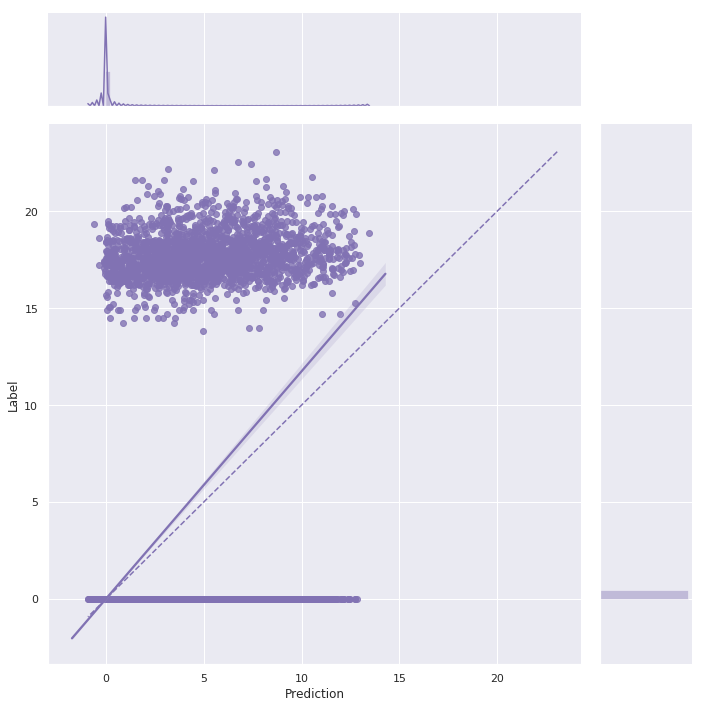

In [27]:
# Make prediction on validation data.
val_predictions = model.predict(X_val, num_iteration=model.best_iteration)
# Get min and max values of the predictions and labels.
min_val = max(max(val_predictions), max(Y_val))
max_val = min(min(val_predictions), min(Y_val))
# Create dataframe with validation predicitons and labels.
val_df = pd.DataFrame({"Label":Y_val})
val_df["Prediction"] = val_predictions
# Plot data
sns.set(style="darkgrid")
sns.jointplot(y="Label", x="Prediction", data=val_df, kind="reg", color="m", height=10)
plt.plot([min_val, max_val], [min_val, max_val], 'm--')
plt.show()

### Model metrics

In [28]:
val_predictions[val_predictions<0] = 0
mse = mean_squared_error(val_predictions, Y_val)
rmse = np.sqrt(mean_squared_error(val_predictions, Y_val))

print('Model validation metrics')
print('MSE: %.2f' % mse)
print('RMSE: %.2f' % rmse)

Model validation metrics
MSE: 3.06
RMSE: 1.75


### Feature importance

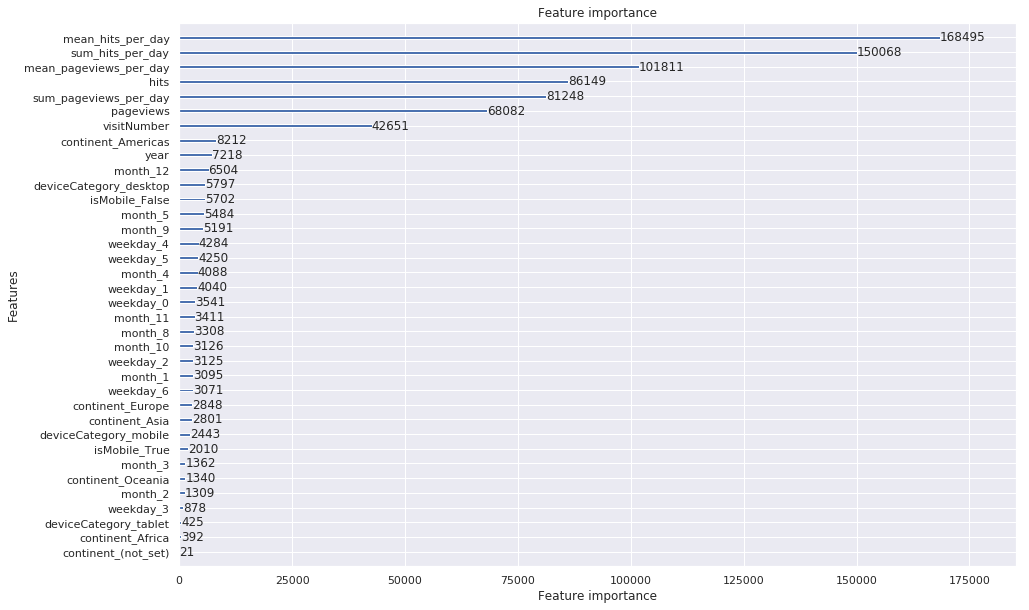

In [29]:
lgb.plot_importance(model, figsize=(15, 10))
plt.show()

In [30]:
predictions = model.predict(test, num_iteration=model.best_iteration)

submission = pd.DataFrame({"fullVisitorId":test_ids})
predictions[predictions<0] = 0
submission["PredictedLogRevenue"] = predictions
submission = submission.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
submission.columns = ["fullVisitorId", "PredictedLogRevenue"]
submission["PredictedLogRevenue"] = submission["PredictedLogRevenue"]
submission.to_csv("submission.csv", index=False)
submission.head(10)

,fullVisitorId,PredictedLogRevenue
0,0000000259678714014,0.453892
1,0000049363351866189,0.026606
2,0000053049821714864,0.007754
3,0000059488412965267,0.025770
4,0000085840370633780,0.005041
5,0000091131414287111,0.000885
6,0000117255350596610,4.545544
7,0000118334805178127,0.000000
8,0000130646294093000,0.000081
9,0000150005271820273,0.001106
